In the manuscript we state that MorF performs at the same level or better than blastp and EggNOG-mapper, annotation pipelines that use sequence similarity. The reviewers challenged us to expand the comparison to more sensitive sequence search options. For ease of comparison we chose to use emapper in profile mode (HMMER). Since we are interested in remote homology we decided to use the HMMs at the `Eukaryota` level of the EggNOG database.

In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2023-01-11 11:56


# Agreement between sequence profile searches and morphologs

We will compare the annotation produced by AlphaFold+FoldSeek against that produced by EggNOG-mapper in `hmmer` mode. If our idea worked well, we should see that in the overwhelming majority of cases the structural pipeline identifies the same annotation for each _Spongilla_ protein.

In [2]:
import glob
from os.path import exists

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from upsetplot import plot as upset

Read the two tables:

In [3]:
morf = pd.read_parquet('../data/results/structure_annotation.parquet')
hmmer = pd.read_csv('../data/profile/slac_hmmer.emapper.annotations', sep='\t', skiprows=4, skipfooter=3, engine='python')
emapper = pd.read_csv('../data/results/Slacustris_eggnog.tsv', sep='\t')

Identify the bit score cut off and threshold the structure annotation:

In [4]:
bitscore_cut_off = np.exp(5)
keep = morf['bit score'] >= bitscore_cut_off
morf = morf[keep].copy()

extract protein IDs from the hmmer results so we can merge:

In [5]:
hmmer["protein_id"] = hmmer["#query"].str.split(".").str[1].astype(int)

How many proteins are annotated by each approach?

In [6]:
morf.shape, hmmer.shape, emapper.shape

((25232, 30), (28897, 22), (17990, 11))

How many proteins don't get a name?

In [7]:
(morf['Preferred_name'] == '-').sum(), (hmmer['Preferred_name'] == '-').sum(), (emapper['Preferred_name'] == '-').sum()

(5206, 11724, 5317)

How many proteins don't get a description?

In [8]:
(morf['Description'] == '-').sum(), (hmmer['Description'] == '-').sum(), (emapper['Description'] == '-').sum()

(38, 2592, 596)

While `emapper-hmmer` annotates more proteins, it also annotates them at a less useful level (no name); effectively, MorF still annotates a larger part of the _Spongilla_ proteome.

# What is the level of detail given by each modality?

We will use the amount of orthogroups as a proxy for that. If annotation via hmmer is more vague we would expect to consistently find less orthogroups listed per protein.

This is an inherently flawed comparison, as MorF looks for the best morpholog, which is going to be a real protein rather than an orthologous group, as is the case for emapper. However, the argument could be made that if MorF agrees with emapper/emapper-hmmer on the eukaryote or root level, then the additional detail brought by using a best-hit approach might be beneficial.

In [9]:
morf['#OGs'] = morf['eggNOG_OGs'].str.split(',').apply(len)
hmmer['#OGs'] = hmmer['eggNOG_OGs'].str.split(',').apply(len)
emapper['#OGs'] = emapper['eggNOG_OGs'].str.split(',').apply(len)

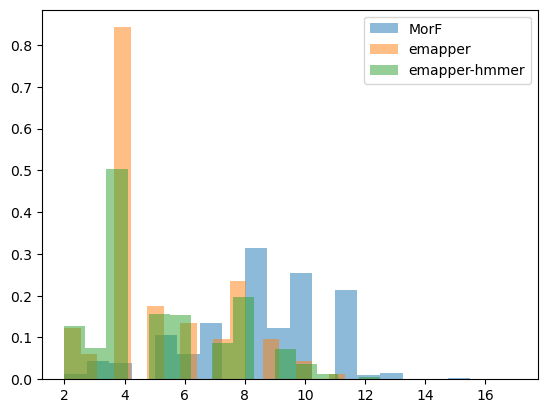

In [10]:
fig, ax = plt.subplots()
ax.hist(morf['#OGs'], bins=20, label='MorF', alpha=0.5, density=True)
ax.hist(emapper['#OGs'], bins=20, label='emapper', alpha=0.5, density=True)
ax.hist(hmmer['#OGs'], bins=20, label='emapper-hmmer', alpha=0.5, density=True)
ax.legend();
fig.savefig('./no_OGs.svg')

In [11]:
from scipy.stats import ks_2samp

In [12]:
methods = ['MorF', 'emapper', 'emapper-hmmer']
no_OGs = [morf['#OGs'], emapper['#OGs'], hmmer['#OGs']]
pvals = np.zeros((3, 3))
stats = np.zeros((3, 3))
for i in range(3):
    for j in range(i, 3):
        stat, pval = ks_2samp(no_OGs[i], no_OGs[j])
        stats[i, j] = stat
        pvals[i, j] = pval

In [13]:
dstat = pd.DataFrame(stats, index=methods, columns=methods)
dpval = pd.DataFrame(pvals, index=methods, columns=methods)

In [14]:
dstat

MorF   emapper  emapper-hmmer
MorF            0.0  0.535453       0.512195
emapper         0.0  0.000000       0.070044
emapper-hmmer   0.0  0.000000       0.000000

In [15]:
dpval

MorF  emapper  emapper-hmmer
MorF            1.0      0.0   0.000000e+00
emapper         0.0      1.0   9.633633e-48
emapper-hmmer   0.0      0.0   1.000000e+00

MorF's distribution is clearly shifted to the right. Let's quantify it:

In [16]:
summaries = {
    'MorF': morf['#OGs'].describe(),
    'emapper': emapper['#OGs'].describe(),
    'emapper-hmmer': hmmer['#OGs'].describe(),
}

pd.DataFrame(summaries)

MorF       emapper  emapper-hmmer
count  25232.000000  17990.000000   28897.000000
mean       8.283767      5.213897       5.350486
std        2.327989      2.077985       2.231996
min        2.000000      2.000000       2.000000
25%        7.000000      4.000000       4.000000
50%        8.000000      4.000000       5.000000
75%       10.000000      7.000000       7.000000
max       17.000000     13.000000      16.000000

Interesting to see that the standard deviation is essentially the same in all distributions! MorF annotates, on average, 3 more OGs per protein. This is probably a product of how it works, namely by getting a best hit and assigning all its information to the query protein, but since standard `emapper` and `emapper-hmmer` are essentially the same distribution this may be more important.

# How much does each modality annotate?

We will visualize the different subsets of annotation overlap with an upset plot.

In [17]:
total_proteins = 41943

In [18]:
sequence = np.intersect1d(emapper['protein_id'], hmmer['protein_id'])
in_all = np.intersect1d(sequence, morf['protein_id'])

hmmer_morf = np.intersect1d(morf['protein_id'], hmmer['protein_id'])
hmmer_morf = np.setdiff1d(hmmer_morf, emapper['protein_id'])

emapper_morf = np.intersect1d(morf['protein_id'], emapper['protein_id'])
emapper_morf = np.setdiff1d(emapper_morf, hmmer['protein_id'])

emapper_hmmer = np.intersect1d(hmmer['protein_id'], emapper['protein_id'])
emapper_hmmer = np.setdiff1d(emapper_hmmer, morf['protein_id'])

morf_only = np.setdiff1d(morf['protein_id'], hmmer['protein_id'])
morf_only = np.setdiff1d(morf_only, emapper['protein_id'])

hmmer_only = np.setdiff1d(hmmer['protein_id'], morf['protein_id'])
hmmer_only = np.setdiff1d(hmmer_only, emapper['protein_id'])

emapper_only = np.setdiff1d(emapper['protein_id'], morf['protein_id'])
emapper_only = np.setdiff1d(emapper_only, hmmer['protein_id'])

In [19]:
all_annotated = np.concatenate((morf['protein_id'], hmmer['protein_id'], emapper['protein_id']))
all_unique = np.unique(all_annotated)

In [20]:
counts = [
    total_proteins - len(all_unique),
    len(morf_only),
    len(hmmer_only),
    len(hmmer_morf),
    len(emapper_only),
    len(emapper_morf),
    len(emapper_hmmer),
    len(in_all),
]

In [21]:
result = {
    'emapper': [False, False, False, False, True, True, True, True],
    'emapper-hmmer': [False, False, True, True, False, False, True, True],
    'MorF': [False, True, False, True, False, True, False, True],
    'counts': counts
}

overlap = pd.DataFrame(result)
overlap.set_index(['emapper', 'emapper-hmmer', 'MorF'], inplace=True)

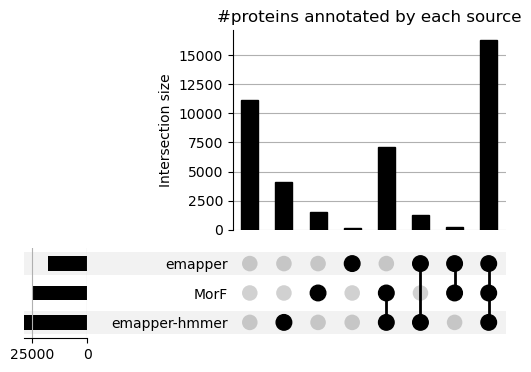

In [22]:
subplots = upset(overlap, sum_over='counts')
subplots['intersections'].set_title('#proteins annotated by each source');
plt.savefig('./upset.svg')

This plot demonstrates the sensitivity of sequence profiles; there aren't many annotations that HMMER doesn't find :)

a sanity check:

In [23]:
overlap.sum()

counts    41943
dtype: int64

this makes sense. Now let's have a look at the IDs that overlap:

In [24]:
sequence = np.intersect1d(emapper['protein_id'], hmmer['protein_id'])
keep = np.intersect1d(sequence, morf['protein_id'])

len(keep)

16346

We will compare the level of detail and the agreement between the three modalities. Let's start by subsetting the tables before merging:

In [25]:
morf = morf.set_index("protein_id").loc[keep].copy()
emapper = emapper.set_index("protein_id").loc[keep].copy()
hmmer = hmmer.set_index("protein_id").loc[keep].copy()

In [26]:
orthogroups = emapper[['eggNOG_OGs']].join(hmmer[['eggNOG_OGs']],  lsuffix='_emapper', rsuffix='_hmmer').join(morf[['eggNOG_OGs']])

In [27]:
orthogroups.columns = ['emapper', 'hmmer', 'morf']

## EggNOG most specific OrthoGroup level

this is the ideal scenario: for how many cases do the annotation pipelines put a gene in the same group of orthologous genes? Extract the EggNOG OG information and compare. We will always examine both ways (source 1 included in source 2 or vice versa) and count both cases as positives.

In [28]:
def keep_last(row):
    """
    A function to isolate the root EggNOG orthogroup.
    
    Expects a comma-separated string where the root orthogroup
    contains the word 'root'.
    """
    x = np.array(row.split(','))
    return x[-1]

In [29]:
for source in ['emapper', 'hmmer', 'morf']:
    orthogroups['most_specific_' + source] = orthogroups[source].apply(keep_last)

Compare the root orthogroup lists of each gene between tables. Hitting at least one is considered a success.

In [30]:
def contains_OG(row, source1='morf', source2='emapper', base='most_specific_'):
    if row[base + source1] is None or row[base + source2] is None:
        return None
        
    s1_contains_s2 = row[base + source1] in row[source2]
    s2_contains_s1 = row[base + source2] in row[source1]    
    return s1_contains_s2 | s2_contains_s1

In [31]:
for s1, s2 in [
    ('morf', 'hmmer'),
    ('morf', 'emapper'),
    ('hmmer', 'emapper')
]:
    orthogroups['ms_' + s1 + '_' + s2] = orthogroups.apply(contains_OG, axis=1, args=(s1, s2))

## EggNOG eukaryote level OG

since for HMMER we used the eukaryote level OGs, we would expect the significant overlap to happen there:

In [32]:
def keep_euk(row):
    """
    A function to isolate the root EggNOG orthogroup.
    
    Expects a comma-separated string where the root orthogroup
    contains the word 'root'.
    """
    x = np.array(row.split(','))
    for og in x:
        if "Eukaryota" in og:
            return og
    else:
        return None

In [33]:
for source in ['emapper', 'hmmer', 'morf']:
    orthogroups['euk_' + source] = orthogroups[source].apply(keep_euk)

See if the eukaryote orthogroup is shared between modalities.

In [34]:
for s1, s2 in [
    ('morf', 'hmmer'),
    ('morf', 'emapper'),
    ('hmmer', 'emapper')
]:
    orthogroups['euk_' + s1 + '_' + s2] = orthogroups.apply(contains_OG, axis=1, args=(s1, s2, 'euk_'))

## EggNOG root OrthoGroup level

this is the most pertinent level: for how many cases do the two annotation pipelines put a gene in the same group of orthologous genes? Extract the EggNOG OG information and compare. To facilitate the comparison we will only look at the root level, but we could extend this as much as we want (e.g. pick the most specific orthogroup for structure and ask if it is found in the sequence annotation).

Isolate the root orthogroup for each peptide. If multiple root orthogroups are present, keep all of them.

In [35]:
def keep_root(row):
    """
    A function to isolate the root EggNOG orthogroup.
    
    Expects a comma-separated string where the root orthogroup
    contains the word 'root'.
    """
    x = np.array(row.split(','))
    keep = np.zeros(len(x), dtype=bool)
    for i, og in enumerate(x):
        keep[i] = 'root' in og
#     print(x, keep)
    return x[keep]

In [36]:
for source in ['emapper', 'hmmer', 'morf']:
    orthogroups['root_' + source] = orthogroups[source].apply(keep_root)

Compare the root orthogroup lists of each gene between tables. Hitting at least one is considered a success.

In [37]:
def is_contained_in(row, x='eggNOG_OGs_struct', y='eggNOG_OGs_seq'):
    overlap = np.intersect1d(row[x], row[y])
    return len(overlap) > 0

In [38]:
for s1, s2 in [
    ('morf', 'hmmer'),
    ('morf', 'emapper'),
    ('hmmer', 'emapper')
]:
    
    orthogroups['root_' + s1 + '_' + s2] = orthogroups.apply(is_contained_in, axis=1, args=('root_' + s1, 'root_' + s2))

# Overlap agreement

Here we will just print the results:

In [39]:
for s1, s2 in [
    ('morf', 'hmmer'),
    ('morf', 'emapper'),
    ('hmmer', 'emapper')
]:
    specific_overlap = orthogroups['ms_' + s1 + '_' + s2].sum()
    euk_overlap = orthogroups['euk_' + s1 + '_' + s2].sum()
    root_overlap = np.sum(orthogroups['root_' + s1 + '_' + s2]).sum()
    print(f'{s1} and {s2}:')
    total = len(keep)
    print(f'\t- most specific OG: {specific_overlap} / {total} ({specific_overlap / total * 100:.2f}%)')
    total = np.sum(~(orthogroups['euk_' + s1].isnull() | orthogroups['euk_' + s2].isnull()))
    print(f'\t- eukaryotic OG: {euk_overlap} / {total} ({euk_overlap / total * 100:.2f}%)')
    total = len(keep)
    print(f'\t- root OG: {root_overlap} / {total} ({root_overlap / total * 100:.2f}%)')

morf and hmmer:
	- most specific OG: 7959 / 16346 (48.69%)
	- eukaryotic OG: 13038 / 15889 (82.06%)
	- root OG: 14251 / 16346 (87.18%)
morf and emapper:
	- most specific OG: 9280 / 16346 (56.77%)
	- eukaryotic OG: 14030 / 15745 (89.11%)
	- root OG: 14827 / 16346 (90.71%)
hmmer and emapper:
	- most specific OG: 10909 / 16346 (66.74%)
	- eukaryotic OG: 13828 / 16032 (86.25%)
	- root OG: 14899 / 16346 (91.15%)


Where do the orthogroups come from? Do the methods differ in the level of detail they provide?

In [40]:
orthogroups['most_specific_hmmer'].str.split('|').str[-1].value_counts()[:10]

Metazoa           6658
Bilateria         1613
Eukaryota         1140
Actinopterygii     913
Chordata           768
Arthropoda         519
Vertebrata         464
Opisthokonta       444
Poales             355
Lepidoptera        210
Name: most_specific_hmmer, dtype: int64

In [41]:
orthogroups['most_specific_emapper'].str.split('|').str[-1].value_counts()[:10]

Metazoa           7692
Bilateria         1340
Actinopterygii    1146
Eukaryota          970
Chordata           705
Vertebrata         627
Opisthokonta       398
Rodentia           273
Mammalia           251
Arthropoda         233
Name: most_specific_emapper, dtype: int64

In [42]:
orthogroups['most_specific_morf'].str.split('|').str[-1].value_counts()[:10]

Actinopterygii     3216
Rodentia           3160
Hominidae          2291
Vertebrata          749
Drosophilidae       668
Cetartiodactyla     646
Chromadorea         597
Bilateria           486
Poales              399
Rhabditida          389
Name: most_specific_morf, dtype: int64

Standard emapper and `emapper-hmmer` have a very similar top 10, with many representatives from rather broad categories (eukaryotes, metazoa, bilateria). I was expecting this for HMMER, but not for emapper.